In [34]:
from numpy import genfromtxt
import matplotlib.pyplot as plt
#!pip install mplfinance
import mplfinance as mpf
from mplfinance.original_flavor import candlestick2_ochl, candlestick_ohlc
import numpy as np
import pandas as pd
import uuid
import time
import shutil
import os
import sys
from datetime import datetime
from packaging import version

#import tensorflow as tf
#from tensorflow import keras
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"
import keras

from keras import optimizers
from keras.layers import Dropout, Flatten, Dense, Activation, BatchNormalization
from keras.layers import Convolution2D, MaxPooling2D, Conv2D
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

#!pip install opencv-python
import cv2

%load_ext tensorboard

data = "data2"
train = data + "/train/"
validation=  data + "/validation/"
buy = "buy/"
sell = "sell/"

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [35]:
n_samples = len(os.listdir(train+buy)) + len(os.listdir(train+sell))

# get image dimensions
img_path = os.listdir(data + "/train/buy")[10]
im = cv2.imread(data + "/train/buy/" + img_path)

# create arrays
buy_array = np.empty((len(os.listdir(train+buy)), im.shape[0], im.shape[1], 3))
sell_array = np.empty((len(os.listdir(train+sell)), im.shape[0], im.shape[1], 3))


# fill buy array
files = os.listdir(train + buy)
for i, f in enumerate(files):
    if f.endswith(".png"):
        im = cv2.imread("data2/train/buy/" + f)
        buy_array[i] = keras.preprocessing.image.img_to_array(im)
buy_array /= 255
        
# fill sell array
files = os.listdir(train + sell)
for i, f in enumerate(files):
    if f.endswith(".png"):
        im = cv2.imread("data2/train/sell/" + f)
        sell_array[i] = keras.preprocessing.image.img_to_array(im)
sell_array /= 255


# combine and shuffle arrays
np.random.seed(42)
x_train = np.append(buy_array, sell_array, axis=0)
y_train = np.append(np.ones(len(buy_array)), np.zeros(len(sell_array)))
p = np.random.permutation(len(x_train))
x_train = x_train[p]
y_train = y_train[p]

In [36]:
x_train.shape

(8336, 140, 144, 3)

In [5]:
img_width = im.shape[0]
img_height = im.shape[1]


# Enter the number of samples, training + validation
nb_filters1 = 16
nb_filters2 = 16
nb_filters3 = 32
conv1_size = 3
conv2_size = 2
conv3_size = 5
pool_size = 2
# We have 2 classes, buy and sell
classes_num = 2
batch_size = 128
chanDim = 3



### custom model
model = Sequential()
model.add(Convolution2D(nb_filters1, conv1_size, padding ='same', input_shape=(img_width, img_height , 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))
model.add(Dropout(0.5))

model.add(Convolution2D(nb_filters2, conv2_size, padding ="same"))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(pool_size, pool_size), data_format='channels_last'))
model.add(Dropout(0.5))

model.add(Convolution2D(nb_filters3, conv3_size, padding ='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(pool_size, pool_size), data_format='channels_last'))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.summary()
model.compile(loss='binary_crossentropy',
                      optimizer=optimizers.Adam(),
                      metrics=['accuracy'])

callbacks_list = [
    #OneCycle(min_lr=7e-6, max_lr=7e-2, min_mtm = 0.85, max_mtm = 0.95, annealing_stage=0.1, annealing_rate=0.01, training_iterations=np.ceil(((183*epochs)/(batch_size)))),
    #keras.callbacks.ModelCheckpoint("best_model.h5", save_best_only=True, monitor="val_loss" ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 140, 144, 16)      448       
_________________________________________________________________
activation_5 (Activation)    (None, 140, 144, 16)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 70, 72, 16)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 70, 72, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 70, 72, 16)        1040      
_________________________________________________________________
activation_6 (Activation)    (None, 70, 72, 16)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 35, 36, 16)        0         
__________

In [7]:
#0. original - 95% training - 50% validation - overfitting (10000 images)
#1. added 0.1 dropout after each moxpooling and changed from image_generator to numpy array - 15 epochs - 95% training - 50% validation - still overfitting
#2. increased each conv dropout to 0.25 - 20 epochs - 96% training - 50% validation - still overfitting
#3. increased each conv dropout to 0.50 - 20 epochs - 84% training - 50% validation - still overfitting
#4. removed last conv layer - 15 epochs - 84% training - 50% validation - still overfitting
#5. added last layer back, decreased # filters in each conv layer by 1/2 (16,16,32) - 20 epochs -  75% training - 50% validation - still overfitting
#6. decreased # filters in each conv layer by 1/2 again (8,8,16) - 20 epochs -  62% training - 50% validation - still overfitting
#7. decreased # filters in each conv layer by 1/2 again (4,4,8) - 20 epochs -  60% training - 50% validation - still overfitting
#8. decreased # filters in each conv layer by 1/2 again (2,2,4) - 40 epochs -  64% training (still increasing) - 50% validation - still overfitting
#9. decreased # filters in each conv layer by 1/2 again (1,1,2) - 100 epochs -  58% training (still increasing) - 50% validation - still overfitting
#10. decreased batch size from 128 to 16 - 100 epochs -  60% training (still increasing) - 50% validation - still overfitting
#11. Going back to #5 with 3x the number of images (30000) - 56% training - 50% validation - still overfitting
history = model.fit(x_train, y_train, epochs=20, verbose=1, batch_size=128, shuffle=True, callbacks=callbacks_list, validation_split=0.2)

model.save("my_model")

Train on 24002 samples, validate on 6001 samples
Epoch 1/20
24002/24002 [==============================] - 125s 5ms/step - loss: 0.6922 - acc: 0.5175 - val_loss: 0.6931 - val_acc: 0.5016
Epoch 2/20
24002/24002 [==============================] - 116s 5ms/step - loss: 0.6919 - acc: 0.5191 - val_loss: 0.6931 - val_acc: 0.5016
Epoch 3/20
24002/24002 [==============================] - 111s 5ms/step - loss: 0.6916 - acc: 0.5228 - val_loss: 0.6931 - val_acc: 0.5016
Epoch 4/20
24002/24002 [==============================] - 110s 5ms/step - loss: 0.6914 - acc: 0.5223 - val_loss: 0.6930 - val_acc: 0.5196
Epoch 5/20
24002/24002 [==============================] - 110s 5ms/step - loss: 0.6911 - acc: 0.5258 - val_loss: 0.6929 - val_acc: 0.5082
Epoch 6/20
24002/24002 [==============================] - 111s 5ms/step - loss: 0.6907 - acc: 0.5314 - val_loss: 0.6931 - val_acc: 0.5071
Epoch 7/20
24002/24002 [==============================] - 111s 5ms/step - loss: 0.6893 - acc: 0.5370 - val_loss: 0.6928 - v

KeyboardInterrupt: 

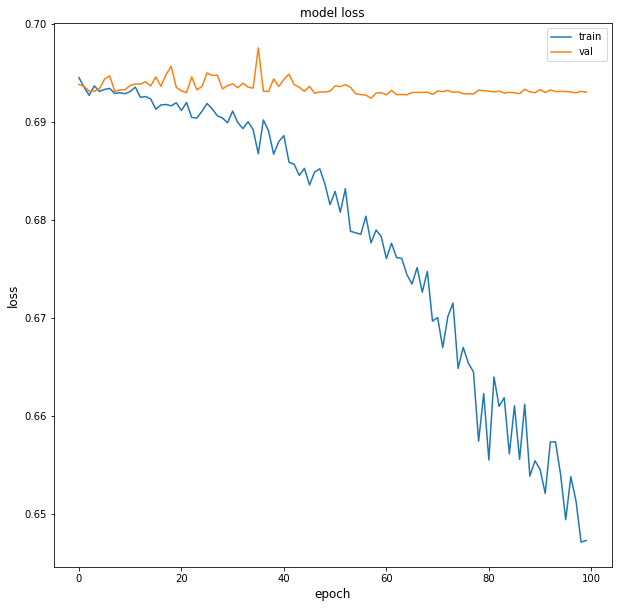

In [65]:
# show traning/validation plots
metric = "loss"
plt.figure(figsize=(10,10))
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

In [13]:
y_pred = model.predict(x_train)

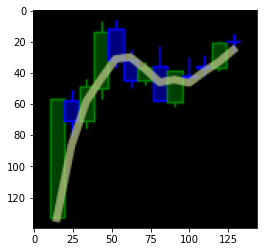

In [47]:
plt.imshow(x_train[1])

In [16]:
y_train.shape

(10637,)